In [ ]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from copy import deepcopy

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

# PC network setup functions

In [ ]:
# Define relu activation function
relu = lambda x: jnp.maximum(0, x)

### Init #######################################################################

# Intialize parameters of network
def init_params(hps) -> list:
  '''Returns arrays of initial activities and weights.
  Also returns a key for random generation.
  Inputs:
  Layer sizes and random seed.
  '''

  def init_weights(sizes: list, key) -> list:
    keys = random.split(key, num=len(sizes))
    return [jnp.array(random_layer_params(m, n, k)) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

  def random_layer_params(m: int, n: int, key):
    '''Returns a jax array of random numbers in (n, m) shape.
    This version is He initialization.
    '''
    scale = jnp.sqrt(2/m)
    return scale * random.normal(key, (n, m))

  activities = [jnp.zeros(s) for s in hps['sizes']]
  key = random.PRNGKey(hps['seed'])
  key, subkey = random.split(key)
  weights = init_weights(hps['sizes'], subkey)

  return activities, weights, key

### Usage #######################################################################

@jit
def ff(activities, weights):
  '''A one-step feedforward pass. Returns activities.
  Requires (l-1) calls to do full feedforward pass.
  '''
  new_acts = deepcopy(activities)

  for l in range(len(activities)-1):
    new_acts[l+1] = jnp.matmul(weights[l], relu(activities[l]))

  return new_acts

### Energy function and training ##########################################################################
def energy(activities, weights, activity_history, hps):
  '''Calculates overall prediction loss.
  If beta==1 then noise is only based on the most recent activity.
  '''

  beta = hps['noise_beta']
  C = hps['denom_constant']

  # Update activity_history values
  # (1-beta) * previous_activity_history + beta * new_activity
  for l in range(len(activity_history)):
    activity_history[l] = (1-beta) * activity_history[l] + beta * activities[l]

  energy_sum = 0
  for l in range(len(activities)-1):
    energy_sum += jnp.sum((1/2) * ((activities[l+1] - jnp.matmul(weights[l], relu(activities[l]))) / (jnp.abs(activity_history[l+1]) + C)) ** 2)

  return energy_sum

@jit
def update_acts_energy(activities, weights, activity_history, hps):
  act_grads = grad(energy, argnums=0)(activities, weights, activity_history, hps)
  return [act - hps['gamma'] * d_act for act, d_act in zip(activities, act_grads)]

@jit
def update_weights_energy(activities, weights, activity_history,  hps):
  w_grads = grad(energy, argnums=1)(activities, weights, activity_history, hps)
  return [w - hps['alpha'] * d_w for w, d_w in zip(weights, w_grads)]


### Noise and clip functions ##########################################################################

@jit
def act_noise(activities, activity_history, key, hps):
  ''' Adds noise to each neuron based on its past activity.
  '''

  noise_scale = hps['noise_scale']

  new_activities = [[] for _ in activities]
  for l in range(len(activities)):

    key, subkey = random.split(key)
    noise = random.normal(subkey, activities[l].shape) * noise_scale
    new_activities[l] = activities[l] + noise

  return new_activities, activity_history, key

@jit
def weight_noise(weights, key, hps):
  '''Adds some noise to the weights.
  '''
  new_weights = [[] for _ in weights]
  for l in range(len(weights)):
    key, subkey = random.split(key)
    noise = random.normal(subkey, weights[l].shape) * hps['weight_noise_scale']
    new_weights[l] = weights[l] + noise

  return new_weights, key

@jit
def weight_clip(weights, cap=2.):
  '''Makes sure weights don't go above some magnitude.
  '''
  new_weights = [[] for _ in weights]
  for l in range(len(weights)):
    new_weights[l] = jnp.clip(weights[l], -cap, cap)

  return new_weights


### Log ##########################################################################

class PCNLog():
  ''' Records all current variables in the network.
  .acts[i][t][n] is a list of activities for the ith layer, timestep t, neuron n.
  '''
  def __init__(self, hps):

    self.acts = [[] for _ in range(len(hps['sizes']))]
    self.weights = [[] for _ in range(len(hps['sizes'])-1)]

  def record(self, activities, weights):
    [self.acts[i].append(acts) for i,acts in enumerate(activities)]
    [self.weights[i].append(weights) for i,weights in enumerate(weights)]

  def close(self):
    self.weights = [np.array(w) for w in self.weights]

# Example of agent adjusting to changing environment faster over time without context cue

## Functions to control environment and track the agent's response to reward

In [ ]:
def get_environment_state(t, timescale):

  """
  This function returns an environmental state, either 0 or 1, that switches
  according to the timescale specified.

  TODO: edit function to allow for n states that can take values specified by an array

  Arguments:
  t: current time
  timescale: time that passes between state switches
  """

  # Start at 0, switch every timescale units of time
  if (t // timescale) % 2 == 0:
    return 0
  else:
    return 1

In [ ]:
def get_environment_stimuli(environment_state, reward0, reward1):

  """
  This function takes in the current environment state and outputs the
  associated bandit rewards, either reward0 for state=0 or reward1 for
  state=1.

  TODO: edit to allow for n rewards based on n states from edited
        get_environment_state function
  """

  # State 1 is associated with reward1
  if environment_state:
    return reward1
  else:
    return reward0

In [ ]:
# Define bandit task
def bandit(motors, rewards=[0.1, 0.01, 1.]):
  lever_ind = jnp.argmax(motors)
  return rewards[lever_ind], lever_ind

In [ ]:
# Define function to track the motor neuron responses to reward inputs
def get_motor_neuron_response(activities, weights, reward):

  """This function returns the activity of the two motor neurons given the specified reward """

  # Feed each input and record output
  activities[0] = jnp.array([reward])
  for l in range(2):
    activities = ff(activities, weights)
  return np.array(activities[-1])

## Run agent

In [ ]:
# Set up experiment
timesteps = 100_000
sizes = [1, 30, 2]
start_seed = 12655
rewards = [0., 0.5]
timescale = 10000


# Set initial reward and environment input
initial_reward_input = 0.5
initial_input = jnp.array([initial_reward_input])  # first neuron is for reward, second for environ


# Initialize array to save motor neuron outputs given reward
motor_neuron_acts_given_reward = []


# Set network parameters
hps = {

    'sizes' : sizes,

    'gamma' : 0.01, # Activity update rate
    'alpha' : 0.01, # Weight update rate

    'noise_beta'  : 0.01,  # Activity history update rate for noise scale
    'denom_constant' : 0.25, # Constant to add to denominator in energy term
    'noise_scale' : 0.01, # Activity noise scale

    'weight_noise_scale' : 0.01, # Weight noise scale

    'seed' : start_seed,

}

# Initialize activities and weights
activities, weights, key = init_params(hps)
activity_history = deepcopy(activities)

# Initialize loggers
log = PCNLog(hps)
levers = np.zeros(timesteps)
energies = np.zeros(timesteps)

# Initialize activities to start
activities[0] = initial_input
reward_history = jnp.array([0.])

## Run agent
for t in range(timesteps):

  if t%10000==0:
    print(t)
    print(rewards)

  # Get possible rewards from current environment
  current_env = get_environment_state(t, timescale)
  rewards = get_environment_stimuli(current_env, [0., 0.5], [0.5, 0.])

  # Interact with bandit task
  reward, levers[t] = bandit(activities[-1], rewards=rewards)

  # Update activities
  activities = update_acts_energy(activities, weights, activity_history, hps)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  # Update weights
  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)

  # Give agent reward as sensory input
  activities[0] = jnp.array([reward])

  # Log
  log.record(activities, weights)
  energies[t] = energy(activities, weights, activity_history, hps)

  # Save motor neuron activities given reward = 0.5
  motor_neuron_acts_given_reward.append(list(get_motor_neuron_response(activities, weights, reward=0.5)))

<ipython-input-12-4801f6ff9b2a>:8: RuntimeWarning: Mean of empty slice
  rolling_average[i] = np.nanmean(levers[i-window_size:i])


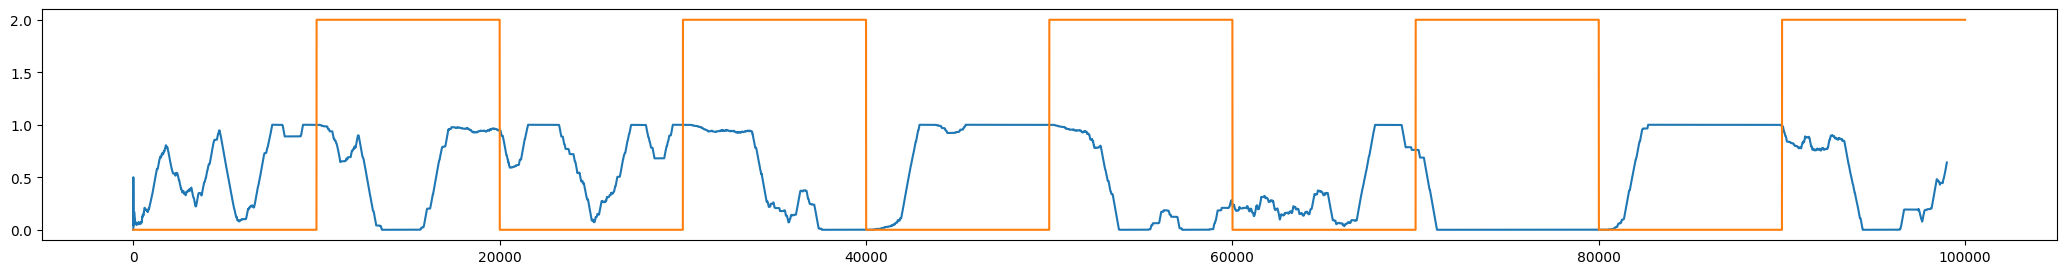

In [ ]:
## Plot rolling average of pct time spent in lever 1

# Get rolling average
n = 1000
rolling_average = np.zeros(len(levers)-n+1)
for i in range(len(levers)-n+1):
    window_size = min(i, n)
    rolling_average[i] = np.nanmean(levers[i-window_size:i])

# Plot
plt.figure(figsize=(26,3))
plt.plot(rolling_average, label="% correct lever pulls over last 1000 timesteps")
plt.plot([get_environment_state(t, timescale) * 2 for t in range(timesteps)], label="Environment State")
plt.xlabel("timestep")
plt.legend()

# It looks like it's learning!

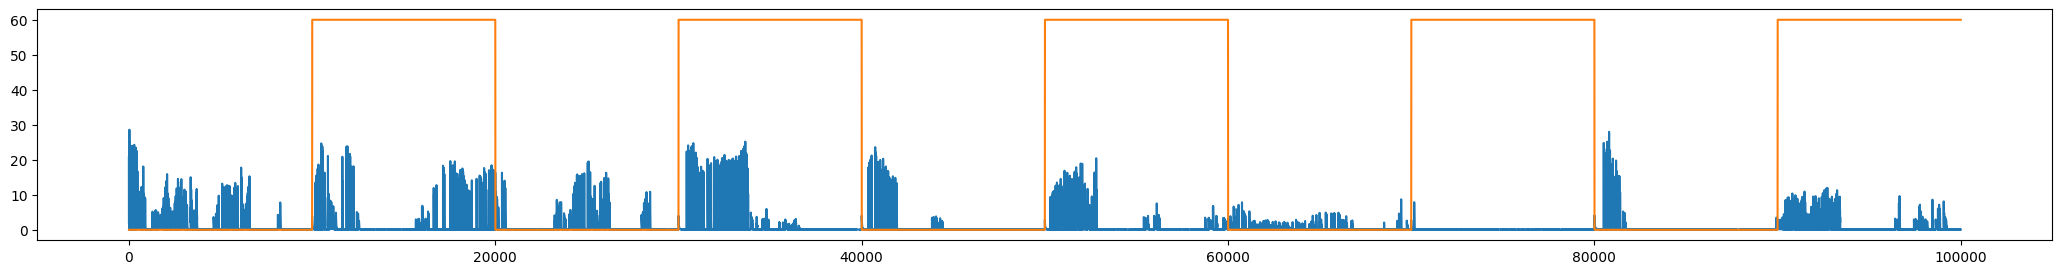

In [ ]:
# Plot energies too
plt.figure(figsize=(26,3))
plt.plot(energies)
plt.plot([get_environment_state(t, timescale) * 60 for t in range(timesteps)])

Text(0.5, 1.0, 'Difference in motor neuron activities evaluated at reward=0.5')

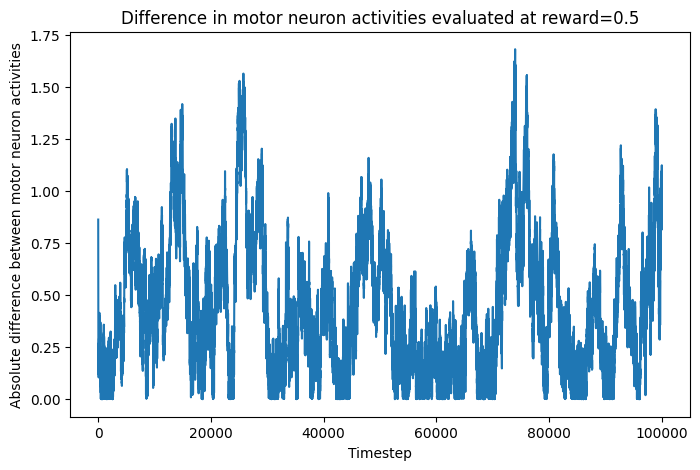

In [ ]:
# plot differennce between two motor neuron activities with reward=0.5 input as function of timestep
plt.figure(figsize=(8,5))
plt.plot(np.abs(np.array(motor_neuron_acts_given_reward)[:,0] - np.array(motor_neuron_acts_given_reward)[:,1]))
plt.xlabel("Timestep")
plt.ylabel("Absolute difference between motor neuron activities")
plt.title("Difference in motor neuron activities evaluated at reward=0.5")

# Run many seeds to check for the faster adjustment to changing rewards without context cue

### Functions for running the experiment

In [ ]:
def get_environment_state(t, timescale):

  """
  This function returns an environmental state, either 0 or 1, that switches
  according to the timescale specified.

  TODO: edit function to allow for n states that can take values specified by an array

  Arguments:
  t: current time
  timescale: time that passes between state switches
  """

  # Start at 0, switch every timescale units of time
  if (t // timescale) % 2 == 0:
    return 0
  else:
    return 1

In [ ]:
def get_environment_stimuli(environment_state, reward0, reward1):

  """
  This function takes in the current environment state and outputs the
  associated bandit rewards, either reward0 for state=0 or reward1 for
  state=1.

  TODO: edit to allow for n rewards based on n states from edited
        get_environment_state function
  """

  # State 1 is associated with reward1
  if environment_state:
    return reward1
  else:
    return reward0

In [ ]:
def bandit(motors, rewards=[0.1, 0.01, 1.]):
  lever_ind = jnp.argmax(motors)
  return rewards[lever_ind], lever_ind

In [ ]:
## Define function to get rolling average over previous n timesteps
def get_rolling_average(array, n):

  # Define array to hold rolling average
  rolling_avg = np.copy(array)

  # Loop through array
  for i in range(len(array)-n+1):

    # Get average over up to n previous timesteps
    window_size = min(i, n)
    rolling_avg[i] = np.nanmean(array[i-window_size:i])

  return rolling_avg

In [ ]:
## Define function to quantify reaction time
def get_reaction_times(sensory_input, timesteps, timescale, n, pct):

  """
  Rough quantification of reaction time of agent to changing environment.

  Reaction time is defined as the number of timesteps from the change in environment
  until the agent is getting the reward for n steps pct% of the time. If the agent
  never switches to the other environment, the maximum time n is assigned.

  Return an array the reaction time for each environment change. Note that these
  will always be >=n, by definition.
  """

  # Normalize rewards so that they are zero and one (fix for generality later)
  sensory_input = (sensory_input - np.min(sensory_input)) / (np.max(sensory_input) - np.min(sensory_input))

  # Define number of transitions
  num_transitions = timesteps // timescale

  # Separate levers for each segment of constant environment
  sensory_input_per_env = np.array(sensory_input).reshape(int(len(sensory_input) / timescale), timescale)

  # Initialize array to store reaction times
  reaction_times = np.zeros(num_transitions)

  # Loop through stationary environment phases
  for env in range(num_transitions):

    # Get rolling average of up to previous n timesteps for this environment phase
    rolling_input_per_env = get_rolling_average(sensory_input_per_env[env], n=n)

    # Get locations where the agent is has been getting the reward 90% of the time over n steps
    reward_locs = np.argwhere(rolling_input_per_env[n:] > pct)

    if len(reward_locs) != 0:
      # Get first time this occurs
      reaction_times[env] = np.min(reward_locs) + n
    else:
      # This never occurs, assign max time
      reaction_times[env] = n


  return reaction_times

In [ ]:
# Define function to run exact agent defined above w given start seed
def run_agent(start_seed):

  """
  This function runs the agent with 100,000 timesteps and an environment alternation rate
  of 10,000. It returns an array with the agent's reaction time after each environment change,
  as defined by the get_reaction_time function.

  TODO: fix this up to work for general agent network size, timescale, timesteps, etc. too tired rn
  """


  ########################## RUN AGENT ##############################
  # Define rewards
  timesteps = 100_000
  sizes = [1, 30, 2]
  rewards = [0., 0.5]
  timescale = 10000

  # Set initial reward and environment input
  initial_reward_input = 0.5

  initial_input = jnp.array([initial_reward_input])  # first neuron is for reward, second for environ


  hps = {

      'sizes' : sizes,

      'gamma' : 0.01, # Activity update rate
      'alpha' : 0.01, # Weight update rate

      'noise_beta'  : 0.01,  # Activity history update rate for noise scale
      'denom_constant' : 0.25, # Constant to add to denominator in energy term
      'noise_scale' : 0.01, # Activity noise scale

      'weight_noise_scale' : 0.01, # Weight noise scale

      'seed' : start_seed,

  }

  activities, weights, key = init_params(hps)
  activity_history = deepcopy(activities)

  log = PCNLog(hps)
  levers = np.zeros(timesteps)
  energies = np.zeros(timesteps)

  activities[0] = initial_input

  reward_history = jnp.array([0.])

  for t in range(timesteps):

    if t%10000==0:
      print(t)
      print(rewards)

    # Get environment stimulus
    #environment_stimulus = 0.  # TODO: change later

    # Get rewards from current environment
    current_env = get_environment_state(t, timescale)  # delete after we start updating stimulus. just use this! or we could introduce delay at some point! this is type of injury. cool
    rewards = get_environment_stimuli(current_env, [0., 0.5], [0.5, 0.])

    reward, levers[t] = bandit(activities[-1], rewards=rewards)

    activities = update_acts_energy(activities, weights, activity_history, hps)
    activities, activity_history, key = act_noise(activities, activity_history, key, hps)

    weights = update_weights_energy(activities, weights, activity_history, hps)
    weights, key = weight_noise(weights, key, hps)
    weights = weight_clip(weights, cap=1.)

    activities[0] = jnp.array([reward])

    log.record(activities, weights)
    energies[t] = energy(activities, weights, activity_history, hps)


  ###################### POST PROCESSING ##################################

  # Convert sensory activities (reward) log into array
  rewards_received = np.array([float(act[0]) for act in log.acts[0]])

  # Get reaction times
  reaction_times = get_reaction_times(rewards_received, timesteps, timescale, n=1000, pct=0.9)

  return reaction_times

### Script

In [ ]:
# Number of agents to run
num_agents = 100

# Set start seeds to try
start_seeds = np.linspace(1, 200000, num_agents).astype("int")

# Define array to hold reaction times for all agents
all_agent_reaction_times = np.zeros((len(start_seeds), 10))

# Loop through start seeds, getting reaction time for each agent
for idx, seed in enumerate(start_seeds):

  # Run agent, get reaction times
  reaction_times = run_agent(seed)

  # Save data
  all_agent_reaction_times[idx] = reaction_times


# Get median reaction time for each environment window
med_reaction_times = np.median(all_agent_reaction_times, axis=0)

# Get std for each time window
stds = np.std(all_agent_reaction_times, axis=0)


# Plot results
plt.figure(figsize=(10,5))
plt.errorbar(range(10), med_reaction_times, yerr=stds, fmt='o')
plt.xlabel("Environment window number")
plt.ylabel("Median reactions speed")

# Experiments on network with densely connected context neuron

In [ ]:
# Change env to 0.55 for consistency with Chenguang
def get_environment_state(t, timescale):

  """
  This function returns an environmental state, either 0 or 1, that switches
  according to the timescale specified.

  TODO: edit function to allow for n states that can take values specified by an array

  Arguments:
  t: current time
  timescale: time that passes between state switches
  """

  # Start at 0, switch every timescale units of time
  if (t // timescale) % 2 == 0:
    return 0
  else:
    return 0.55

In [ ]:
# Set experimental conditions
timesteps = 60_000
timescale = 10000 # environmental oscillation period
start_seed = 12655
rewards = [0., 0.5]

# Set initial reward and environment input
initial_reward_input = 0.5
initial_environment_context = 0.55
initial_input = jnp.array([initial_reward_input, initial_environment_context])  # first neuron is for reward, second for environ

# Set network architecure
sizes = [2, 30, 2]

# Set network paramters
hps = {

    'sizes' : sizes,

    'gamma' : 0.01, # Activity update rate
    'alpha' : 0.01, # Weight update rate

    'noise_beta'  : 0.01,  # Activity history update rate for noise scale
    'denom_constant' : 0.25, # Constant to add to denominator in energy term
    'noise_scale' : 0.01, # Activity noise scale

    'weight_noise_scale' : 0.01, # Weight noise scale

    'seed' : start_seed,

}

# Initialize activities, weights, and logs
activities, weights, key = init_params(hps)
activity_history = deepcopy(activities)
log = PCNLog(hps)
levers = np.zeros(timesteps)
energies = np.zeros(timesteps)
activities[0] = initial_input
reward_history = jnp.array([0.])


## Run agent
for t in range(timesteps):

  # Get rewards from current environment
  current_env = get_environment_state(t, timescale)
  rewards = get_environment_stimuli(current_env, [0., 0.5], [0.5, 0.])

  if t%10000==0:
    print(t)
    print(rewards)

  # Interact
  reward, levers[t] = bandit(activities[-1], rewards=rewards)

  # Update activities
  activities = update_acts_energy(activities, weights, activity_history, hps)
  activities, activity_history, key = act_noise(activities, activity_history, key, hps)

  # Update weights
  weights = update_weights_energy(activities, weights, activity_history, hps)
  weights, key = weight_noise(weights, key, hps)
  weights = weight_clip(weights, cap=1.)

  # Sense reward and context cue
  activities[0] = jnp.array([reward, current_env])

  # Record
  log.record(activities, weights)
  energies[t] = energy(activities, weights, activity_history, hps)

0
[0.0, 0.5]
10000
[0.5, 0.0]
20000
[0.0, 0.5]
30000
[0.5, 0.0]
40000
[0.0, 0.5]
50000
[0.5, 0.0]


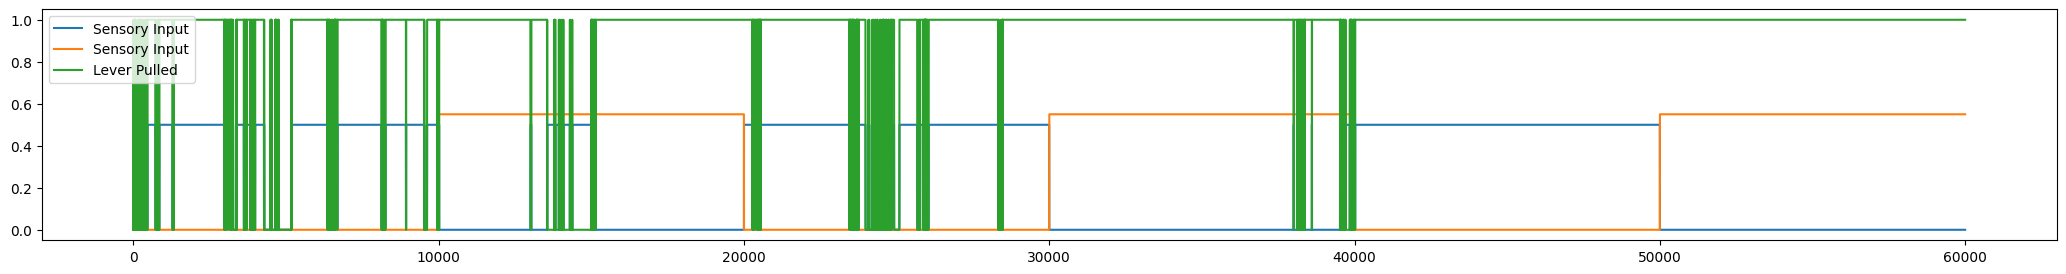

In [ ]:
# Plot results
plt.figure(figsize=(26,3))
plt.plot(log.acts[0], label="Sensory Input")
plt.plot(levers, label="Lever Pulled")
plt.legend()